In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from IPython.display import display, SVG
from matplotlib import pyplot as plt
from PIL import Image

from ccai_client import API, File
from ccai_client.file_classes import PathologySlideNode

from histpat_toolkit.masks import (
    single_color_to_svg,
    masks_to_svg,
    mask_to_contours
)

In [3]:
api = API(organization="platform", save_token_to=".auth.json")

In [4]:
root = File.get_root(api)
folders = root.children()
for folder in folders:
    print(f"ID: {folder.id}, Name: {folder.name}")

ID: aff11b40-0233-4d31-9b50-a155af9a1100, Name: Moje pliki
ID: 6f518e11-2408-4620-87eb-440f99245a28, Name: Pliki organizacji


In [5]:
folder = File.get(api, id=folders[0].id)
files = folder.children()
for file in files:
    print(f"ID: {file.id}, Name: {file.name}")

ID: 9a0a92ab-44e7-41d8-96f9-3d921d74ff05, Name: R0LPW2B
ID: 94b82ddb-c2ce-48f8-887c-24b02f734cc1, Name: dicom
ID: 678f4796-2c6b-4279-92a0-9354b9c61fb7, Name: sample
ID: 4e97236b-0b13-4df8-87f5-bee8799035e2, Name: R0LPW2A


In [6]:
slide = File.get(api, id=files[0].id)
assert isinstance(slide, PathologySlideNode)

### Masks to contours


MASK 0


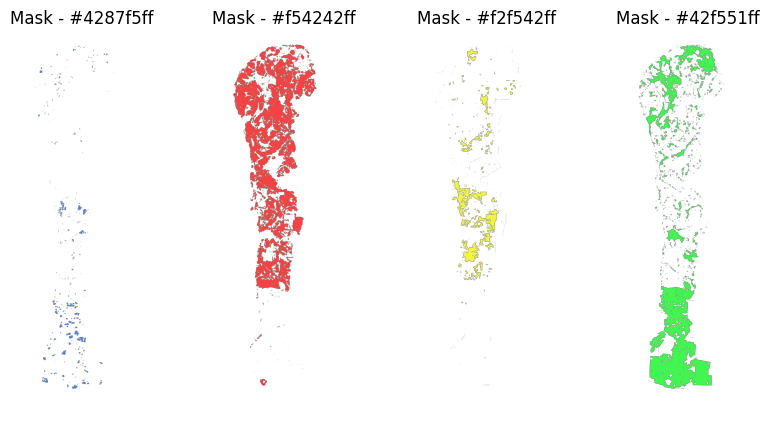

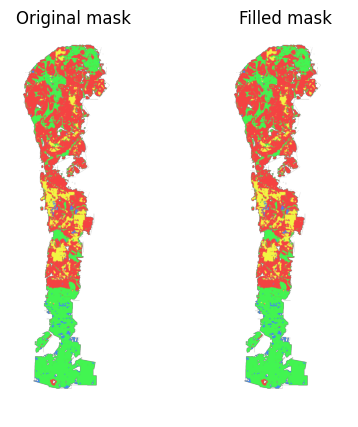

In [ ]:
import cv2 as cv

all_masks_contours = []

for i, tiled_mask in enumerate(slide.list_tiled_masks()):
    mask_pyramid = slide.get_tiled_mask_pyramid(tiled_mask)
    try:
        scale = mask_pyramid.get_scale_for(magnification=2)
    except ValueError:
        scale = 0.1 * mask_pyramid.scale

    mask_image = mask_pyramid.full_image(scale)
    Image.fromarray(mask_image).save(f"data/{slide.name}_mask_{i}.png")

    contours_for_mask = mask_to_contours(
        mask_image=mask_image, 
        colors=tiled_mask.color_map.colors,
        approx_epsilon_ratio=0.005
    )
    all_masks_contours.append(contours_for_mask)

    print(f"MASK {i}")
    mask_filled = np.zeros_like(mask_image)
    plt.figure(figsize=(10, 5))

    for j, (contours_list, color) in enumerate(contours_for_mask):
        cv.drawContours(mask_filled, contours_list, -1, color, thickness=-1)

        single_color_mask = np.zeros_like(mask_image)
        cv.drawContours(single_color_mask, contours_list, -1, color, thickness=-1)

        hex_color = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}{color[3]:02x}"
        plt.subplot(1, len(contours_for_mask), j + 1)
        plt.imshow(single_color_mask)
        plt.title(f"Mask - {hex_color}")
        plt.axis("off")

    plt.show()

    Image.fromarray(mask_filled).save(f"data/{slide.name}_filled_mask_{i}.png")

    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_image)
    plt.title("Original mask")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_filled)
    plt.title("Filled mask")
    plt.axis("off")
    plt.show()

### Contours to SVG

R0LPW2B 0 - color masks


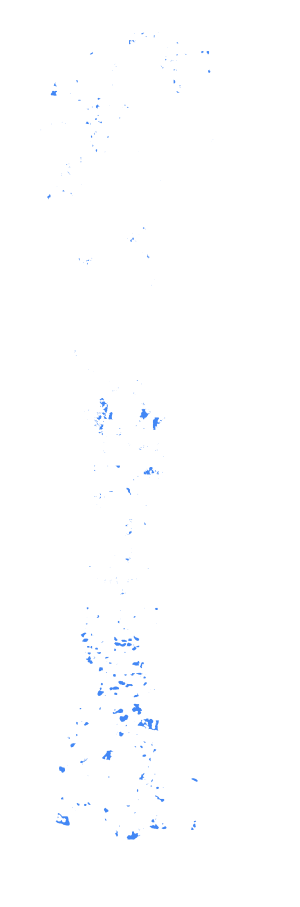

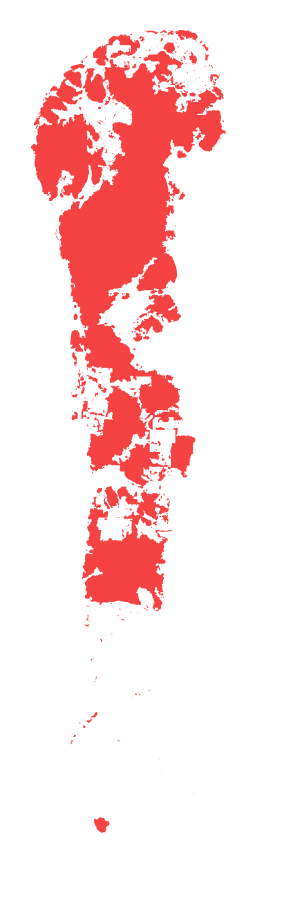

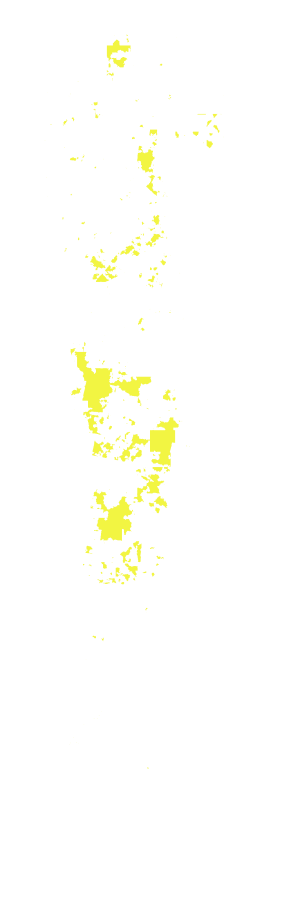

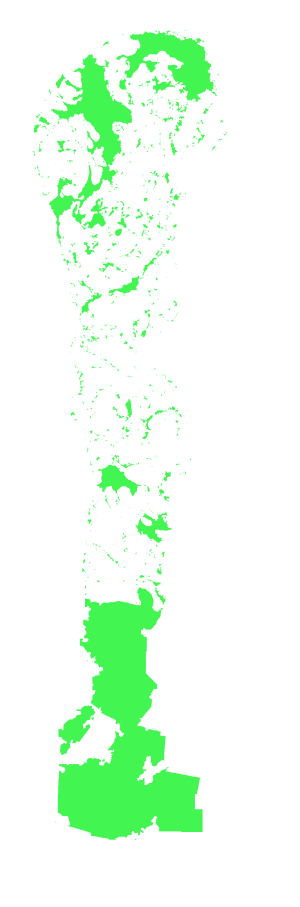

R0LPW2B 0 - full mask


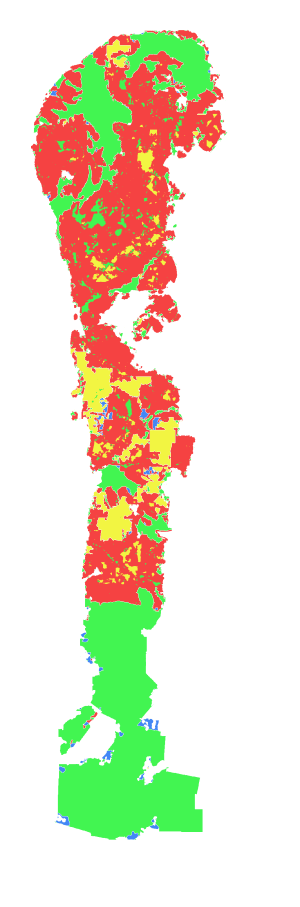

In [8]:
for i, contours_for_mask in enumerate(all_masks_contours):
    print(f"{slide.name} {i} - color masks")
    
    for j, (contours_for_color, color) in enumerate(contours_for_mask):
        svg_single_color = single_color_to_svg(
            contours_for_color, color, mask_image.shape, display_width=300
        )
        display(SVG(svg_single_color.tostring()))

    svg_combined_mask = masks_to_svg(contours_for_mask, mask_image.shape, display_width=300).tostring()
    with open(f"data/{slide.name}_mask_{i}.svg", "w") as f:
        f.write(svg_combined_mask)
    
    print(f"{slide.name} {i} - full mask")
    display(SVG(svg_combined_mask))
